<a href="https://colab.research.google.com/github/GiX7000/regression-and-classification-with-statisticall-ML/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification.

## 2.1. Classification with K-NN.

In this section, we implement k nearest neighbours classifier with cross-validation on two different datasets.

In [ ]:
# helper imports and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# minmax scaling features function in (0,1)
def minmax_scaling(X):
  """ Performs min-max scaling on the given data in (0, 1) range. """
  X_min = X.min(axis=0) # take the min of feature column
  X_max = X.max(axis=0) # take the max of feature column

  # apply the full formula: X_scaled = X_std*(max-min) + min
  X_std = (X - X_min) / (X_max - X_min)
  X_scaled = X_std

  return X_scaled

# function to check for nan and duplicates
def check_nan_and_drop_duplicates(features, labels):
  """ Checks for Nan values and duplicates in the given dataset. """

  # count Nan values
  features_nan_count = np.isnan(features).sum()
  labels_nan_count = np.isnan(labels).sum()

  # check for duplicates
  unique_features, _, unique_indices = find_unique_labels([tuple(row) for row in features])
  really_unique_labels = labels[unique_indices]

  # calculate the number of duplicates
  num_duplicates = len(features) - len(unique_features)

  # print the results
  print(f"Number of NaN values in features: {features_nan_count}")
  print(f"Number of NaN values in labels: {labels_nan_count}")
  print(f"Number of duplicate rows removed: {num_duplicates}")

  return np.array(unique_features), really_unique_labels

# function to find unique labels, their indexes and their counts
def find_unique_labels(y_train):
  """ Finds the unique labels, their indexes and their counts in the given list. """
  unique_labels = []
  counts = []
  indexes = []

  for idx, label in enumerate(y_train):
    if label not in unique_labels:
      unique_labels.append(label)
      counts.append(1)
      indexes.append(idx) # store the index of the firts occurences
    else:
      counts[unique_labels.index(label)] += 1
  return unique_labels, counts, indexes

def create_proportional_subset(features, labels, subset_size):
  """ Creates a subset of subset_size of the given dataset with the same labbbel distribution. """
  # storage lists for features and labels subsets
  subset_features = []
  subset_labels = []

  # find unique labels and their counts
  unique_labels, counts, _ = find_unique_labels(labels)

  # calculate the proportions
  proportions = counts / np.sum(counts)

  # loop over the classes
  for label, proportion in zip(unique_labels, proportions):

    # get the indices of the current class
    indices = np.where(labels == label)[0]

    # create the proportional size for the current class
    proportional_size = int(proportion * subset_size)

    # select random samples with proportional size
    subset_indices = np.random.choice(indices, size=proportional_size)

    # add the selected samples to the subsets
    subset_features.append(features[subset_indices])
    subset_labels.append(labels[subset_indices])

  # concatenate the feature and labels subsets of both classes into one subset feature matrix and labels vector, respectively
  subset_features = np.vstack(subset_features)
  subset_labels = np.hstack(subset_labels)

  return subset_features, subset_labels

In [ ]:
# additional supporting functions

# euclidean distance function
def euclidean_distance(x1, x2):
  """ Calculates the euclidean distance between two points(vectors). """
  return np.sqrt(np.sum((x1 - x2)**2))

# check accuracies function with the simplest way
def check_accuracy(y_test, y_pred):
  """ Checks the accuracy of the predictions. """
  correct = 0
  for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
      correct += 1
  accuracy = correct / len(y_test)
  return accuracy

# most common labels function
def most_common_labels(labels):
  """ Finds the most common label in a list of labels. """

  # count how many times a label is on the list
  label_counts = {}
  for label in labels:
    if label in label_counts:
      label_counts[label] += 1
    else:
      label_counts[label] = 1

  # find the one that appears most of times
  max_count = 0
  most_common = None
  for label, count in label_counts.items():
    if count > max_count:
      max_count = count
      most_common = label

  return most_common

# k-NN function
def knn(X_train, y_train, x_test, k):
  """ Performs k-NN classification on the given data. """
  y_pred = []
  for x in x_test:
    # calculate the distance of each test point from all training points
    distances = [euclidean_distance(x, x_train) for x_train in X_train]

    # find the k nearest neighbors
    k_indices = np.argsort(distances)[:k]
    k_nearest_labels = [y_train[i] for i in k_indices]

    # predict based on the majority of k nearest labels
    most_common = most_common_labels(k_nearest_labels)
    y_pred.append(most_common)

  return np.array(y_pred)

# cross-validation function
def cross_validation(X, y, k, folds):
  """ Performs cross-validation on the given data for k-NN classifier. """
  fold_size = len(X) // folds # works only for even  partitions for now(2, 4, 6, ...)
  accuracies = []

  # while loading the data, we observed all samples of one class first and then all the samples of the other
  # so, we shuffle the indices(pointers) of the dataset before splitting it
  indices = np.arange(len(X))
  np.random.shuffle(indices)
  X = X[indices]
  y = y[indices]

  for i in range(folds):
    # split the data into training and validation sets for this fold
    start = i * fold_size
    end = (i + 1) * fold_size

    X_val = X[start:end]
    y_val = y[start:end]

    X_train = np.concatenate((X[:start], X[end:])) # X[:start] + X[end:]
    y_train = np.concatenate((y[:start], y[end:])) # y[:start] + y[end:]

    # 'training': predict the labels for the validation set
    y_pred = knn(X_train, y_train, X_val, k)

    # calculate the accuracy for this fold
    accuracy = check_accuracy(y_val, y_pred)
    accuracies.append(accuracy)

    # print the accuracy of the current fold
    print(f"Fold {i + 1}: Accuracy = {accuracy:.2f}")

  return (sum(accuracies) / len(accuracies)) * 100 # the total accuracy is the % of the mean of all calculated accuracies from all partitions

# function to plot the results
def plot_results(x, y):
  plt.figure(figsize=(24,8))
  plt.plot(x, y, color='red')
  plt.title('Classification Accuracy vs. Number of Nearest Neighbors (k)')
  plt.xlabel('Number of Nearest Neighbors (k)')
  plt.xticks(x)  # show k values on the x-axis
  plt.ylabel('Accuracy (%)')
  plt.grid(True)
  plt.show()

In [ ]:
# execute k-NN with cross-validation k and folds values
k = [3, 9, 16, 31, 51, 101, 201, 401, 601] # numbers of neighbors
folds = [6] # number of folds for cross-validation(try for even partitions, in a list in case of trying several partitions later)

### 2.1.1. K-NN on Rice_Cammeo_Osmancik dataset.

We will use the given dataset here and we, first, extract features and labels from the txt file.

In [ ]:
# storage lists for extracted features and labels
features = []
labels = []

# open the txt file and extract features and labels
with open('Rice_Cammeo_Osmancik.txt', 'r') as file:
  #data = file.read()
  #print(data)

  # skip the first 16 metadata lines
  for i in range(16):
    next(file)

  # all lines after DATA(16th row) is our training set: each line is a sample with 7 features and a label
  for line in file:
    #print(line)

    # split the line into elements(which are seperated by ,)
    elements = line.strip().split(',')
    #print(elements)

    # all elements of a line are features except the last which is the label
    label_elements = elements[-1]
    labels.append(label_elements)
    feature_elements = elements[:-1]
    features.append(feature_elements)

We do a quick exploration and preprocess of the data.

In [ ]:
# some process on features and labels
features = np.array(features, dtype=float) # convert features from str to float as a numpy array
label_maping = {'Cammeo': 0, 'Osmancik': 1}
labels = np.array([label_maping[str(label)] for label in labels]) # convert labels from str to int as a numpy array

# a quick check for Nan values and dupliates
features, labels = check_nan_and_drop_duplicates(features, labels)

# also check the balance of the two classes
unique_labels, counts, _ = find_unique_labels(labels)
print("\nUnique Labels:", unique_labels)
print("Counts:", counts)

# print shapes to check correctness
print(f"\nfeatures shape: {features.shape}, labels shape: {labels.shape}")

# print first sample of our training set and its label
print(f"\nFirst sample of the dataset: {features[0]} has the label: {labels[0]}")

# a sample before scaling
print(f"\nA sample before scaling: {features[3]}")

# feature scaling
features = minmax_scaling(features)

# and after scaling
print(f"\nA sample after scaling: {features[3]}")

Number of NaN values in features: 0
Number of NaN values in labels: 0
Number of duplicate rows removed: 0

Unique Labels: [0, 1]
Counts: [1630, 2180]

features shape: (3810, 7), labels shape: (3810,)

First sample of the dataset: [1.52310000e+04 5.25578979e+02 2.29749878e+02 8.50937881e+01
 9.28882003e-01 1.56170000e+04 5.72895527e-01] has the label: 0

A sample before scaling: [1.31760000e+04 4.58342987e+02 1.93337387e+02 8.74483948e+01
 8.91860902e-01 1.33680000e+04 6.40669048e-01]

A sample after scaling: [0.49507129 0.52413567 0.51279953 0.58146143 0.6712268  0.49622011
 0.39395418]


And then, we implement k-NN by using all the above helper functions.

For k = 3 and folds = 6:
Fold 1: Accuracy = 0.91
Fold 2: Accuracy = 0.89
Fold 3: Accuracy = 0.91
Fold 4: Accuracy = 0.91
Fold 5: Accuracy = 0.92
Fold 6: Accuracy = 0.91
Average Accuracy: 90.97%

For k = 9 and folds = 6:
Fold 1: Accuracy = 0.93
Fold 2: Accuracy = 0.91
Fold 3: Accuracy = 0.91
Fold 4: Accuracy = 0.93
Fold 5: Accuracy = 0.93
Fold 6: Accuracy = 0.94
Average Accuracy: 92.26%

For k = 16 and folds = 6:
Fold 1: Accuracy = 0.93
Fold 2: Accuracy = 0.92
Fold 3: Accuracy = 0.93
Fold 4: Accuracy = 0.92
Fold 5: Accuracy = 0.93
Fold 6: Accuracy = 0.93
Average Accuracy: 92.62%

For k = 31 and folds = 6:
Fold 1: Accuracy = 0.93
Fold 2: Accuracy = 0.93
Fold 3: Accuracy = 0.92
Fold 4: Accuracy = 0.92
Fold 5: Accuracy = 0.93
Fold 6: Accuracy = 0.92
Average Accuracy: 92.70%

For k = 51 and folds = 6:
Fold 1: Accuracy = 0.92
Fold 2: Accuracy = 0.92
Fold 3: Accuracy = 0.93
Fold 4: Accuracy = 0.92
Fold 5: Accuracy = 0.94
Fold 6: Accuracy = 0.93
Average Accuracy: 92.78%

For k = 101 and folds 

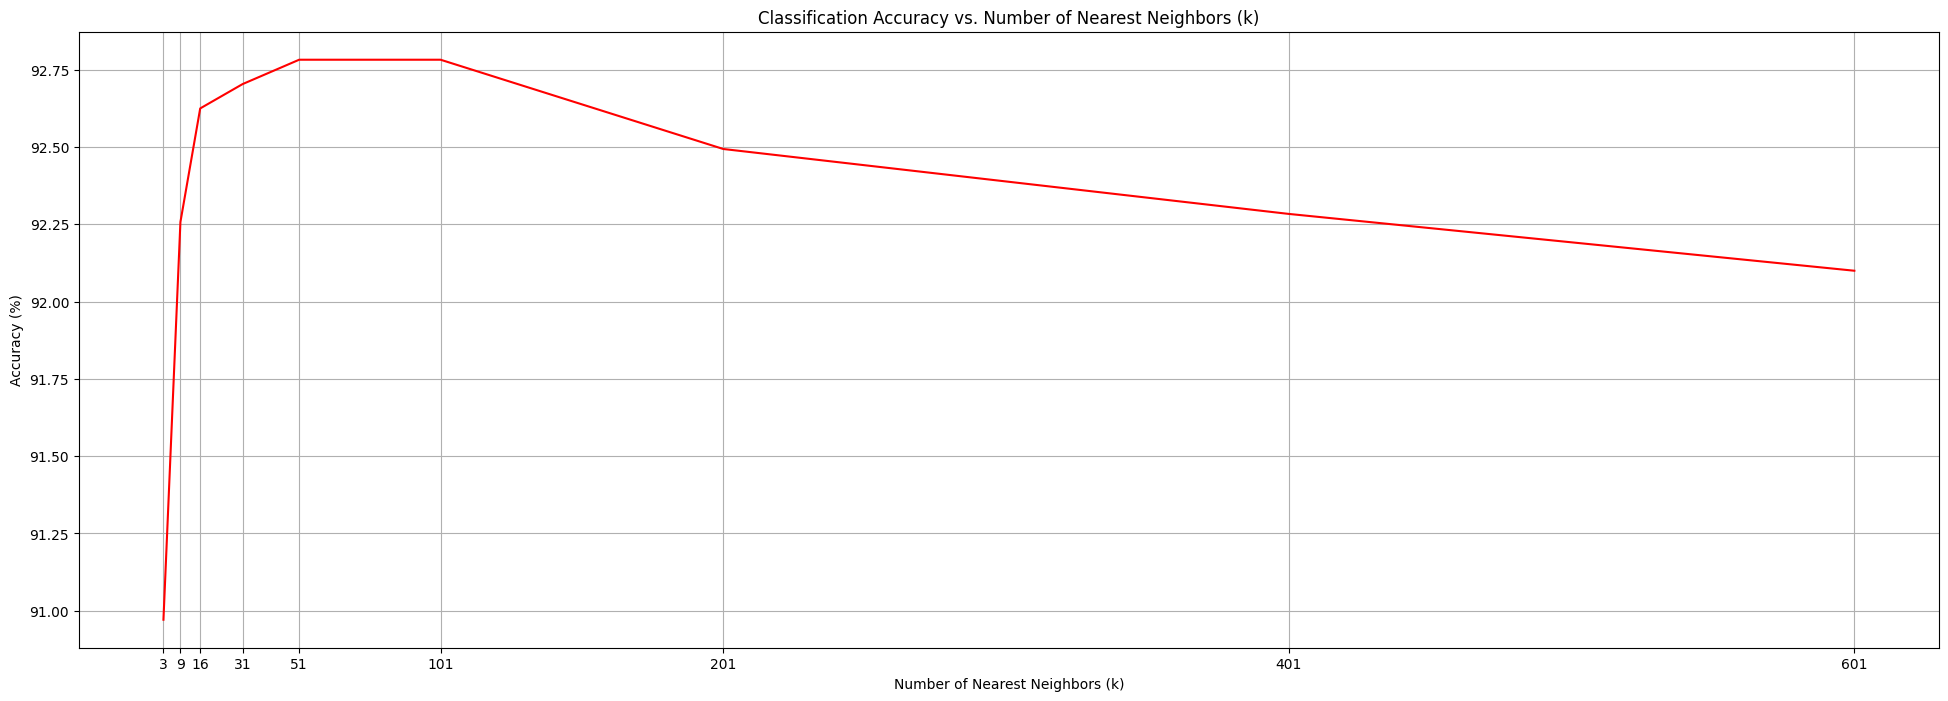

In [ ]:
# storage list for accuracies
accuracies_1 = []

# loop over k values and perform cross-validation
for k_value in k:

  for fold_value in folds:
    print(f"For k = {k_value} and folds = {fold_value}:")
    accuracy = cross_validation(features, labels, k_value, fold_value) # do the classification job
    accuracies_1.append(accuracy)
    print(f"Average Accuracy: {accuracy:.2f}%\n")
    #print(f"Error: {1-accuracies_1:.2f}%\n)

# plot the results
plot_results(k, accuracies_1)

Initially, as the value of $k$ increases, the accuracy of the k-NN model improves. This happens because the model considers more samples when making decisions, which helps it make more stable and reliable predictions, along with high risk of overfitting. The accuracy reaches a peak around $k = 31$ and $k = 51$. However, as $k$ continues to increase beyond this point, the accuracy starts to decrease. With larger values of $k$, the model includes too many neighbors, some of which may be far away and belong to different classes, making the predictions less relevant to the examined point. This leads the model to loose its previous generalization ability for accurate predictions and the model underfits. Therefore, selecting the optimal $k$ in order to achieve the best performance involves balancing these two effects of overfitting with too small $k$ and underfitting with too large $k$.

### 2.1.2. K-NN on Red_Wine_Quality dataset.

We will use [Red Wine Quality dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) for this second classification task with k-NN. And, again, we will exctract features(attributes of red wine) and labels(quality) from the csv file and then we will implement the k-NN algorithm like we did above.  

In [ ]:
import pandas as pd

# read the csv file and see how it looks like
wine_dataset = pd.read_csv('winequality-red.csv')
dataset_2 = wine_dataset.copy() # let's work onn a copy of this, because of some changes we are going to do
dataset_2.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

As we see, we have features with different scales, for example, chlorides values range under 0.1, while total sulfur dioxide range from 30 to 60. So, for their equally contribution to the results, we need to standarize them, to bring them in the same range, like we did in the previous case. We also divide quality range into two parts: high quality(>5) and low quality otherwise. And finally, we do a quick exploration of the dataset.

In [ ]:
#dataset_2.info()

# create two classes: high quality and low quality
dataset_2["quality"] = np.where(dataset_2["quality"] > 5, 1, 0)
#dataset_2.head()

# define the features and the labels
wine_features = dataset_2.drop("quality", axis=1) # (1599,7) initial shape befor removing duplicates
wine_labels = dataset_2["quality"]
#print(f"\nwine_features shape: {wine_features.shape}, wine_labels shape: {wine_labels.shape}")

# convert them to numpy arrays
wine_features = np.array(wine_features, dtype = float) # convert features from str to float as a numpy array
wine_labels = np.array(wine_labels) # in both cases features and labels are numpy arrays with dtype float and int respectively

# a quick check for Nan values and duplicates
wine_features, wine_labels = check_nan_and_drop_duplicates(wine_features, wine_labels)

# check the balance between the two classes: high(1) and low(0) qualities
wine_unique_labels, counts, _ = find_unique_labels(wine_labels)
print("\nUnique Labels:", wine_unique_labels)
print("Counts:", counts)

# check their shapes
print(f"\nwine_features shape: {wine_features.shape}, wine_labels shape: {wine_labels.shape}")

# print first sample of this training set and its label
print(f"\nFirst sample of the dataset: {wine_features[0]} has the label: {wine_labels[0]}")

# scale the data(very important especially when calculating bics and gradients in the last question)

# a sample before scaling
print(f"\nA sample before scaling: {wine_features[3]}")

# feature scaling
wine_features = minmax_scaling(wine_features)

# and after processing
print(f"\nA sample after scaling: {wine_features[3]}")

Number of NaN values in features: 0
Number of NaN values in labels: 0
Number of duplicate rows removed: 240

Unique Labels: [0, 1]
Counts: [640, 719]

wine_features shape: (1359, 11), wine_labels shape: (1359,)

First sample of the dataset: [ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4   ] has the label: 0

A sample before scaling: [11.2    0.28   0.56   1.9    0.075 17.    60.     0.998  3.16   0.58
  9.8  ]

A sample after scaling: [0.5840708  0.10958904 0.56       0.06849315 0.10517529 0.22535211
 0.19081272 0.58223201 0.33070866 0.1497006  0.21538462]


And we implement the k-NN algorithm. We add some more choices for $k$ here in order to identify the point where accuracy peaks.

For k = 3 and folds = 6:
Fold 1: Accuracy = 0.69
Fold 2: Accuracy = 0.69
Fold 3: Accuracy = 0.73
Fold 4: Accuracy = 0.68
Fold 5: Accuracy = 0.66
Fold 6: Accuracy = 0.71
Average Accuracy: 69.40%

For k = 9 and folds = 6:
Fold 1: Accuracy = 0.75
Fold 2: Accuracy = 0.69
Fold 3: Accuracy = 0.74
Fold 4: Accuracy = 0.72
Fold 5: Accuracy = 0.74
Fold 6: Accuracy = 0.73
Average Accuracy: 73.01%

For k = 16 and folds = 6:
Fold 1: Accuracy = 0.75
Fold 2: Accuracy = 0.73
Fold 3: Accuracy = 0.70
Fold 4: Accuracy = 0.73
Fold 5: Accuracy = 0.69
Fold 6: Accuracy = 0.78
Average Accuracy: 73.01%

For k = 31 and folds = 6:
Fold 1: Accuracy = 0.72
Fold 2: Accuracy = 0.70
Fold 3: Accuracy = 0.75
Fold 4: Accuracy = 0.73
Fold 5: Accuracy = 0.76
Fold 6: Accuracy = 0.74
Average Accuracy: 73.38%

For k = 51 and folds = 6:
Fold 1: Accuracy = 0.77
Fold 2: Accuracy = 0.73
Fold 3: Accuracy = 0.69
Fold 4: Accuracy = 0.76
Fold 5: Accuracy = 0.69
Fold 6: Accuracy = 0.74
Average Accuracy: 73.01%

For k = 101 and folds 

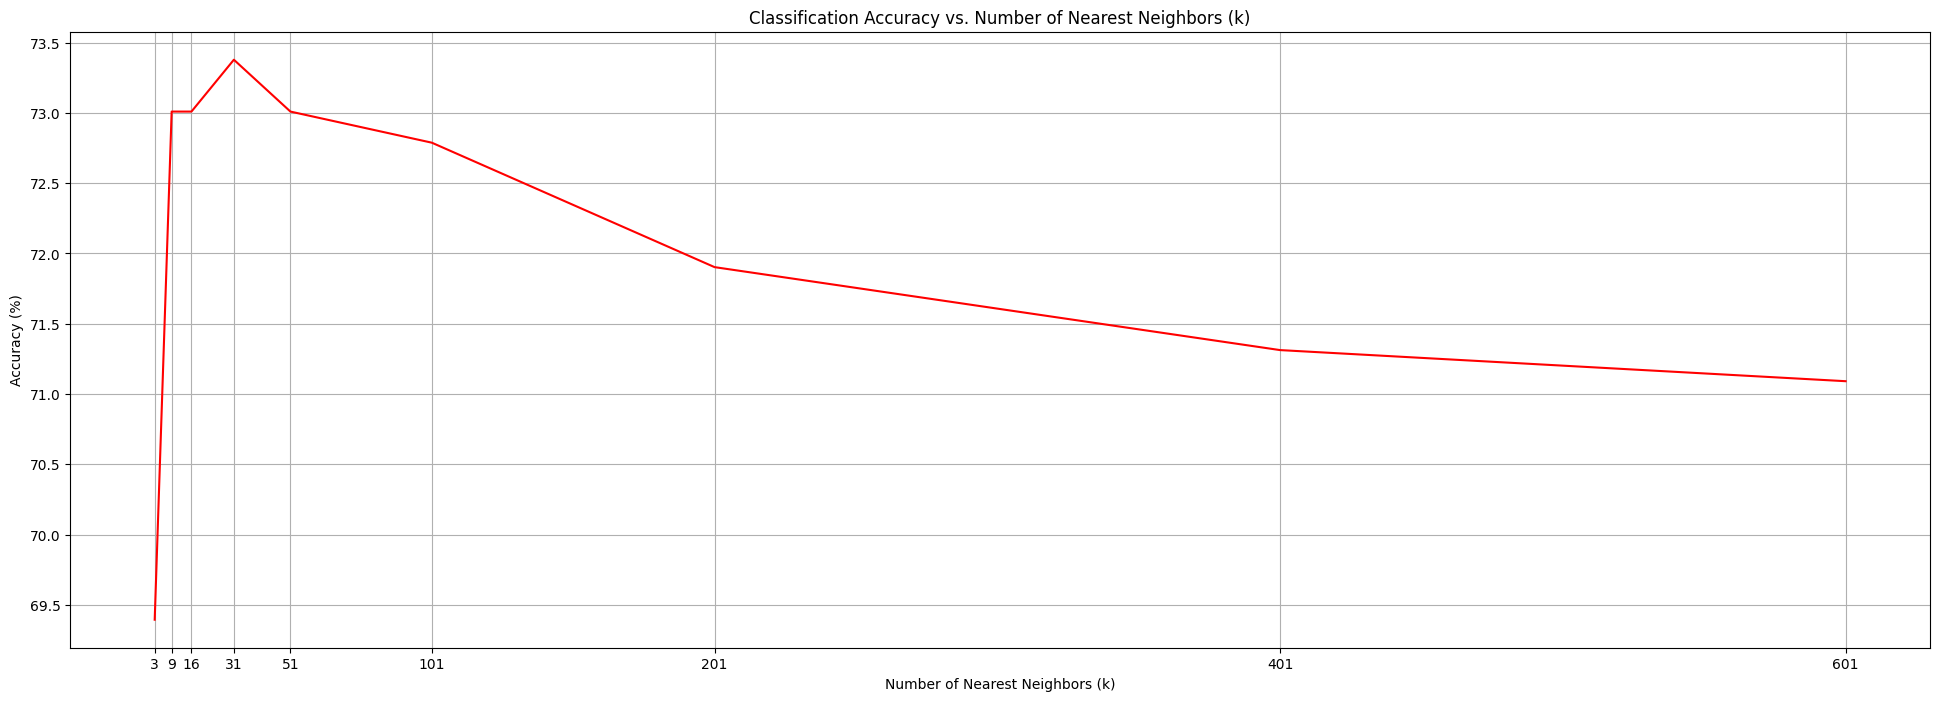

In [ ]:
# storage list for accuracies
accuracies_2 = []

# loop over k values and perform cross-validation
for k_value in k:
  for fold_value in folds:
    print(f"For k = {k_value} and folds = {fold_value}:")
    accuracy = cross_validation(wine_features, wine_labels, k_value, fold_value) # do the classification job
    accuracies_2.append(accuracy)
    print(f"Average Accuracy: {accuracy:.2f}%\n")
    #print(f"Error: {1-accuracies_2:.2f}%\n)

# plot the results
plot_results(k, accuracies_2)

In this case, of a smaller dataset($1359$ samples instead of $3810$ we had previously), the accuracy follows a similar trend: it increases initially with $k$, peaks around when $k = 31$, and then gradually decreases. The smaller dataset size likely reduces the overall accuracy compared to the larger dataset due to less available data for training, which affects generalization. The training time was also much less, while the difference in dimensional feature space between the two datasets($7$ vs. $11$) does not affecet the performance results(we also tried to compare the two datasets by taking the same $N$ with a subset of the first dataset).

To sum up, as $N$ increases and $k$ increases(but small in respect to $N$!), we get higher accuracies. Therefore, the choice of $k$ and $N$(needless to also mention the distribution of the dataset) all influence the performance of $k-NN$ classifier.  

## 2.2. Classification with Bayes.

Given the same two above datasets, with $m$ samples and $n$ features, we will calculate the Bayes and Naive Bayes probabailities under some assumptions. Generally, we want to calculate:

$P(y \mid X) = \frac{P(X \mid y)P(y)}{P(X)}$, where

$P(X \mid y) = \prod_{i=1}^{d} \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left(-\frac{(X - \mu_i)^2}{2\sigma_i^2}\right)$ is the likelihood of all features $d$ when they are independent between each other given class $y$   $(1)$,

$P(X \mid y) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)\right)$ is the joint likelihood of all features $d$ when there is some dependency between each other given class $y$   $(2)$,

$P(y) = \frac{\text{Number of instances of class y}}{\text{Total number of instances}}   (3)$ is the prior probability of $y$, where $y$ can be $c_1$, $c_2$ for our two classes and

$P(X) = P(X \mid y=c_1) \cdot P(y=c_1) + P(X \mid y=c_2) \cdot P(y=c_2)$, which is the marginal probability of $X$ and is ignored as it's the same for both classes and it does not affect the classification decision.

Covariance matrix is given by

$\Sigma =
\begin{bmatrix}
Var(X_1) & Cov(X_2, X_1) & \cdots & Cov(X_d, X_1) \\
Cov(X_1, X_2) & Var(X_2) & \cdots & Cov(X_d, X_2) \\
\vdots & \vdots & \ddots & \vdots \\
Cov(X_1, X_d) & Cov(X_2, X_d) & \cdots & Var(X_d)
\end{bmatrix}$

where $Cov(X_i, X_j) = \frac{1}{n} \sum_{k=1}^{n} (X_{ki} - \mu_i)(X_{kj} - \mu_j)$,

$Var(X_i) = Cov(X_i, X_i) = \frac{1}{n} \sum_{k=1}^{n} (X_{ki} - \mu_i)^2$ and

$Cov(X_i, X_j) = E[(X_i - \mu_i)(X_j - \mu_j)] = Cov(X_j, X_i)   (4)$(symmetric matrix).


For Parzen Window Naive Bayes, the likelihood is:

$P(X|y) = \prod_{i=1}^{d} p(x_i)   (5)$, where

$p(x_i) = \frac{1}{Nh} \sum_{j=1}^{N} K\left(\frac{x_i - x_j}{h}\right)   (6), h = \frac{1}{\sqrt{N}}$ and

$K(u) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{u^2}{2}\right)   (7)$ is the Gaussian kernel.

Naive Bayes classifier assumes full independency between features, whereas Bayes classifier does not and, technically, their difference is in the likelihood calculation.

As we see in the equation of definition of the covariance matrix above, when $\Sigma$ is diagonal with all diagonial elements equal, it means that the features are uncorrelated, as all elements apart from diagonial are zero => no linear correlation between any pair of features(assumption 1). On the other hand, computing the covariance for all pairs of features, including all elements, results a covariance matrix that is not a diagonal(assumption 2).

So, for diagonal and non-diagaonal covariance matrix in first two questions, we use Bayes classifier with equations $2, 3, 4$, beacause we are not sure about full independency between the features. On the contrary, in question 3 with full independency, we use Naive Bayes and the equations $1, 3$. In question 4, we combine equations $3, 5-7$.

Regaridng assumption 5, and as we have said in class, most of times we have data coming from different sources/distributions, which are not gaussians. Although, we can approximate their corresponding pdf with a linear combination of gaussians! So, we can estimate the feature pdfs(likelihood) by using gaussian mixtures for each class, following this equation:

$p(x) = \sum_{k=1}^K P_k \ p(x | k)    (8)$, where $P_k$ is how much each $k$ gaussian $\mathcal{N}(x \mid \mu_k, \Sigma_k)$ participates in the mixture with $\sum_{k=1}^K = 1$. To determine the number of $k$ gaussians that represent the feature space, we should compute the bayesian information criterion(BIC) as $\text{BIC} = -2 \cdot \log(L(\hat{\theta)}) + k \cdot \log(n)$.

Technically, to estimate feature pdfs with gaussian mixtures, we follow the same process and code like [Vincenzo Lavorini](https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4) suggests in the provided attachment. Then, we use the produced with gaussian mixtures likelihood for each class to calculate the posterior probabilities with bayes classifier.

In [ ]:
# helper functions part 1

# gaussian pdf
def gaussian_pdf(x, mean, std):
  """ Calculates the gaussian probability density function. """
  exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
  return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

# multivariate gaussian pdf
def multivariate_gaussian_pdf(x, mean, cov):
  """ Calculates the multivariate gaussian probability density function. """
  d = len(x) # number of features of a x sample
  exponent = np.exp(-0.5 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean)) # use of numpy to get the inverse of cov matrix
  return (1 / (np.sqrt((2 * np.pi) ** d * np.linalg.det(cov))) * exponent) # use of numpy to get the det of cov matrix

# psrzen window pdf
def parzen_window_pdf(x_test, x_train, h):
  """ Calculates the gaussian probability density function with 1-d parzen windows kernel. """
  N = len(x_train)
  kernel = (1/np.sqrt(2 * np.pi)) * np.exp(-(((x_test - x_train) / h) ** 2) / 2)
  return np.sum(kernel) / (N * h)

# likelihood calculation function
def calculate_likelihood(likelihoods):
  """ Calculates the log likelihood of all input likelihoods in d feature space. """
  log_likelihood = 0
  for i in likelihoods:
    log_likelihood += np.log(i) # just take the product of the likelihoods(independent features) => which is the sum of log likelihoods!
  return log_likelihood

# prior calculation function
def calculate_priors(y_train):
  """ Calculates the prior probabilities for each class. """

  # dictionary to store occurences per class
  priors = {}
  # count occurences of each class
  for label in y_train:
    if label in priors:
      priors[label] += 1
    else:
      priors[label] = 1

  # calculate prior probabbilities for each class
  for i in priors:
    priors[i] /= len(y_train)

  return priors

# check prints and shapes function
def print_func(class_label, prior, likelihoods, likelihood, assumption):
  """ Prints intermediate results. """

  if assumption == 'assumption_3':
    print(f"Class {class_label}:")
    print(f"Prior(scalar): {prior}")
    print(f"Likelihoods(list): {likelihoods}")
    print(f"Length of likelihoods(=same as features): {len(likelihoods)}")
    print(f"Likelihood (scalar): {likelihood}")
  else:
    print(f"Class {class_label}:")
    print(f"Prior(scalar): {prior}")
    print(f"Likelihood (scalar): {likelihood}")

# calculate maximum posterior probability function
def max_post(posts):
  for key, value in posts.items():
    if value == max(posts.values()):
      prediction = key
      print(f"Prediction: {prediction}")
      return prediction


In [ ]:
# helper functions part 2

# calculation of pdf properties function (assumptions 1-3)
def calculate_pdf_properties(X_train, assumption):
  """ Calculates the mean and standard deviation (or covariance) of each feature. """

  num_samples = X_train.shape[0] # number of samples
  num_features = X_train.shape[1] # number of features

  # calculate and store the mean(same for both classifiers) for the X_train
  mean = [] # storage list for mean
  for i in range(num_features):
    feature_mean = np.sum(X_train[:, i]) / num_samples
    mean.append(feature_mean)

  # pdf properties in case of naive bayes classifier
  if assumption == 'assumption_3':  # basic std calculation

    # calculate and store the standard deviation of each column/feature of X_train
    std = [] # storage list for standard deviation
    for i in range(num_features):
      feature_std = np.sqrt(sum((X_train[:, i] - mean[i]) ** 2) / num_samples)
      std.append(feature_std)
    print(f"Clssifier: Naive Bayes")
    return mean, std

  # and pdf properties in case of bayes classifier
  else:  # cov calculation

    # calculate the covariance matrix for all feature pairs
    cov = np.zeros((num_features, num_features)) # initiate storage matrix
    for j in range(num_features):
      for k in range(num_features):
        cov[j, k] = np.sum((X_train[:, j] - mean[j]) * (X_train[:, k] - mean[k])) / num_samples

    print(f"Clssifier: Bayes")
    if assumption == 'assumption_1':  # diagonal covariance matrices with all diagonal elements equal to the average
      average_cov = np.sum(cov) / num_features
      cov = np.eye(num_features) * average_cov
      return mean, cov
    elif assumption == 'assumption_2': # non-diagonal covariance matrices
      return mean, cov

# bayes classifier assumptions 1-3
def bayes_classifier(x_test, pdf_properties, priors, assumption=None):
  """ Performs bayes classification on the given data. """

  y_pred = [] # list to store bayes predictions

  for x in x_test:
    print(f"\nSample: {x}")

    posts = {} # dictionary to store prediction list per class

    for class_label, properties in pdf_properties.items():

      prior = priors[class_label]

      if assumption == 'assumption_3':  # naive bayes case
        mean, std = properties # unpack properties dictionary
        likelihoods = [gaussian_pdf(x[i], mean[i], std[i]) for i in range(len(x))]
        likelihood = calculate_likelihood(likelihoods)
        print_func(class_label, prior, likelihoods, likelihood, assumption)

      elif assumption in ['assumption_1', 'assumption_2']: # bayes classifier case
        mean, cov = properties # unpack properties dictionary
        likelihood = multivariate_gaussian_pdf(x, mean, cov)
        print_func(class_label, prior, None, likelihood, assumption)

      # clalculate posterior probabilities
      posts[class_label] = np.log(prior) + np.log(likelihood) # take the log(posterior)=log(likelihood*prior)=log(likelihood) + log(prior)
      print(f"Posterior(scalar): {posts[class_label]}")

    # prediction: having calculated posts for both classes, we take their maximum
    prediction = max_post(posts)
    y_pred.append(prediction)

  return np.array(y_pred)

# naive bayes classifier for assumption 4
def naive_bayes_assumption_4(x_test, x_train, y_train, priors):
  """ Performs naive bayes with parzen window kernel on the given data. """
  y_pred = [] # list to store bayes predictions
  h = 1 / np.sqrt(len(x_train)) # length of the bin, parzen window kernel parameter

  for x in x_test:
    posts = {} # storage dictionary for postriors

    unique_labels, _, _ = find_unique_labels(y_train) # find the different labels of the set
    for label in unique_labels:
      prior = priors[label]
      likelihood = parzen_window_pdf(x, x_train[y_train == label], h)
      posts[label] = np.log(prior) + np.log(likelihood) # check if it's correct
      print_func(label, prior, None, likelihood, 'assumption_4')

    # prediction: having calculated posts for both classes, we take their maximum
    prediction = max_post(posts)
    y_pred.append(prediction)

  print("Classifier: Naive Bayes")
  return np.array(y_pred)

# cross-validation with bayes
def cross_validation_bayes(X, y, folds, assumption=None):
  """ Performs cross-validation on the given data for Bayes classifier. """
  fold_size = len(X) // folds # works only for even  partitions for now(2, 4, 6, ...)
  accuracies = []

  # shuffle the dataset
  indices = np.arange(len(X))
  np.random.shuffle(indices)
  X = X[indices]
  y = y[indices]

  for i in range(folds):
    # split the data into training and validation sets for this fold
    start = i * fold_size
    end = (i + 1) * fold_size

    X_val = X[start:end]
    y_val = y[start:end]

    X_train = np.concatenate((X[:start], X[end:])) # use numpy for X[:start] + X[end:]
    y_train = np.concatenate((y[:start], y[end:])) # use numpy for y[:start] + y[end:]

    # calculate the prior probabilities of y_train
    priors = calculate_priors(y_train)

    if assumption == 'assumption_4': # no need to calculate mean and std or cov here

      y_pred = naive_bayes_assumption_4(X_val, X_train, y_train, priors)

    else: # assumptions 1-3, need to calculate pdf properties for X_train per class

      pdf_properties = {} # storage dictionary for mean and std

      # find the different labels of the set
      unique_labels, _, _ = find_unique_labels(y_train)

      # and iterate over these labels/classes(in our case 2)
      for label in unique_labels:

        # calculate mean, std for the current label/class for the current set/fold and store them in the dictionary
        mean, cov_or_std = calculate_pdf_properties(X_train[y_train == label], assumption)
        pdf_properties[label] = mean, cov_or_std

      # 'training': predict the labels for the validation set using bayes
      y_pred = bayes_classifier(X_val, pdf_properties, priors, assumption)

    # evaluate predictions on the current validation set
    accuracy = check_accuracy(y_val, y_pred)
    accuracies.append(accuracy)

    # print the accuracy of the current fold
    print(f"Fold {i + 1}: Accuracy = {accuracy:.2f}")

  return (sum(accuracies) / len(accuracies)) * 100 # the total validation accuracy is the % of the mean of all calculated validation accuracies from all fold-partitions

In [ ]:
# additional functions for assumption 5
from sklearn.mixture import GaussianMixture as GMM

# mixture gaussian models and bics calculation function
def gmms_bics(X_train, y_train, n_clusters):
  """ Calculates GMMs, BICs for the optimal number of clusters per class. """

  # retrieve unique classes from y
  unique_classes, _, _ = find_unique_labels(y_train)

  # storage dictionaries for models, bics and bics errors
  models = {}
  bics = {}
  bics_err = {}

  # iterate over all classes and calculate gmms and bics
  for label in unique_classes:

    # take the samples of this class
    X_c = X_train[y_train == label]

    # storage lists for gmms, bics and bics_err
    class_bics = []
    class_bics_err = []
    optimal_gmms = []

    for n in n_clusters:
      current_bic = []
      current_gmms = []
      for _ in range(100):
        gmm = GMM(n_components=n, n_init=2).fit(X_c) # params adjusted after errors
        current_bic.append(gmm.bic(X_c))
        current_gmms.append(gmm)

      # calculate the mean and std of bics
      val = np.mean(current_bic)
      err = np.std(current_bic)
      class_bics.append(val)
      class_bics_err.append(err)
      optimal_gmms.append(current_gmms[np.argmin(current_bic)])

    # store gmms, bics and bics_err for the current class
    models[label] = optimal_gmms
    bics[label] = class_bics
    bics_err[label] = class_bics_err

  return models, bics, bics_err # returns storage dictionaries for models, bics, bics_err for each class

# function to plot bics and their gradients
def plot_bic_and_gradient(n_clusters, bics, bics_err):
    """ Plots BIC and its gradients with error bars in subplots. """

    # calculate the gradients of bics
    gradients = np.gradient(bics)

    # check if all shapes are correct
    print(f"n_clusters: {len(n_clusters)}, bics: {len(bics)}, bics_err: {len(bics_err)}, gradients: {len(gradients)}")
    assert len(n_clusters) == len(bics) == len(bics_err) == len(gradients), "Shapes do not match!"

    plt.figure(figsize=(12, 6))

    # Plot BIC
    plt.subplot(1, 2, 1)
    plt.errorbar(n_clusters, bics, yerr=bics_err, label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC")
    plt.legend()

    # Plot Gradient of BIC
    plt.subplot(1, 2, 2)
    plt.errorbar(n_clusters, gradients, yerr=bics_err, label='Gradients of BIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("Number of Clusters")
    plt.ylabel("grad(BIC)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# optimal gmms selection function
def optimal_gmms(gmms, n_clusters, optimal_n_clusters_dict):
  """ Selects the optimal GMMs for each class based on the optimal_n_clusters_dict. """
  # storage dictionary for optimal gmms
  best_gmms = {}

  # retrieve optimal gmms for each class
  for label in optimal_n_clusters_dict:
    best_gmms[label] = gmms[label][optimal_n_clusters_dict[label]]

  return best_gmms

# bayes classifier for assumption 5
def bayes_assumption_5(x_test, gmms, priors):
  """ Performs Bayes classification with GMM likelihoods on the given data. """
  y_pred = []  # List to store predictions

  for x in x_test:
    posts = {} # storage dictionary for posterior probabilities for each class

    for label, gmm in gmms.items():
      prior = priors[label]
      likelihood = gmm.score(x.reshape(1, -1))  # use GMM's score method for log-likelihood
      posts[label] = np.log(prior) + likelihood  # calculate log posterior probability
      print_func(label, prior, None, likelihood, 'assumption_5')

    # prediction: the class with the highest posterior probability
    prediction = max_post(posts)
    y_pred.append(prediction)

  print("Classifier: Bayes")
  return np.array(y_pred)

# cross-validation specifically for assumption 5
def cross_validation_bayes_assumption_5(X, y, folds, optimal_gmms):
    """ Performs cross-validation for Bayes classifier for assumption 5. """
    fold_size = len(X) // folds
    accuracies = []

    # shuffle the dataset
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    for i in range(folds):
      # split the data into training and validation sets for this fold like we did in other cases
      start, end = i * fold_size, (i + 1) * fold_size
      X_val, y_val = X[start:end], y[start:end]
      X_train = np.concatenate((X[:start], X[end:]))
      y_train = np.concatenate((y[:start], y[end:]))

      # calculate the priors for current the training set
      priors = calculate_priors(y_train)

      # perform classification using bayes_assumption_5 and optimal gmms found
      y_pred = bayes_assumption_5(X_val, optimal_gmms, priors)

      # calculate accuracy for the current fold
      accuracy = np.mean(y_pred == y_val)
      accuracies.append(accuracy)

      print(f"Fold {i + 1}: Accuracy = {accuracy:.2f}")

    return np.mean(accuracies) * 100

### 2.2.1. Bayes Classifiers on Rice_Cammeo_Osmancik dataset.

In [ ]:
# assumption 1
folds = 4  # number of folds for cross-validation
assumption = 'assumption_1'  # assumption

# reminder: features var contains feature matrix and labels var contains target vector for dataset_1

# apply the classifier
accuracy = cross_validation_bayes(features, labels, folds, assumption)
print(f"\nAverage Cross-Validation Accuracy (Assumption 1): {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 22.82303442048375
Posterior(scalar): 2.2830350577868392
Prediction: 1

Sample: [0.36639676 0.28044953 0.17114022 0.70179504 0.22749499 0.36594585
 0.73399963]
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 0.009675439065686567
Posterior(scalar): -5.199706724318692
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 4.531407176827612
Posterior(scalar): 0.6662972765364192
Prediction: 1

Sample: [0.22601655 0.23471844 0.24866677 0.36884863 0.65360275 0.22802391
 0.75568314]
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 0.015803254097211693
Posterior(scalar): -4.70908146932442
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 20.095197162353355
Posterior(scalar): 2.1557455895832875
Prediction: 1

Sample: [0.4069706  0.38357293 0.35514019 0.58865333 0.54774987 0.40629395
 0.83265618]
Class 0:
Prior(scalar): 0.57032890

In [ ]:
# assumption 2
assumption = 'assumption_2'  # update assumption

# apply the classifier
accuracy = cross_validation_bayes(features, labels, folds, assumption)
print(f"\nAverage Cross-Validation Accuracy (Assumption 2): {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 549196.820024916
Posterior(scalar): 12.371476912881484
Prediction: 1

Sample: [0.36639676 0.28044953 0.17114022 0.70179504 0.22749499 0.36594585
 0.73399963]
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 4.623036471384642e-89
Posterior(scalar): -203.9605636070678
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 3.134764843864173
Posterior(scalar): 0.29781891155709017
Prediction: 1

Sample: [0.22601655 0.23471844 0.24866677 0.36884863 0.65360275 0.22802391
 0.75568314]
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 0.1711155753626066
Posterior(scalar): -2.3269581361585514
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 12671548.420994539
Posterior(scalar): 15.510134506649147
Prediction: 1

Sample: [0.4069706  0.38357293 0.35514019 0.58865333 0.54774987 0.40629395
 0.83265618]
Class 0:
Prior(scalar): 0.5703289

In [ ]:
# assumption 3
assumption = 'assumption_3'  # update assumption

# apply the classifier
accuracy = cross_validation_bayes(features, labels, folds, assumption)
print(f"\nAverage Cross-Validation Accuracy (Assumption 3): {accuracy:.2f}%")

Clssifier: Naive Bayes
Clssifier: Naive Bayes

Sample: [0.67593733 0.87923163 0.90121587 0.53241739 0.88801055 0.69391702
 0.20757716]
Class 0:
Prior(scalar): 0.23722883135059483
Likelihoods(list): [2.1964420529460726, 0.6272435468722999, 0.21114826201657763, 3.0497812948266865, 0.6642087096048366, 2.10277435575945, 1.1006660485259037]
Length of likelihoods(=same as features): 7
Likelihood (scalar): 0.3103078061796943
Posterior(scalar): -2.6089206215141956
Class 1:
Prior(scalar): 0.7627711686494052
Likelihoods(list): [0.008447218942296148, 4.247374218974901e-05, 3.2937962758154484e-07, 3.588621433317535, 0.07741446583972388, 0.0067264907371579205, 0.8175111275588837]
Length of likelihoods(=same as features): 7
Likelihood (scalar): -36.25060334652669
Posterior(scalar): nan
Prediction: 0

Sample: [0.62533005 0.71409491 0.64808716 0.67066313 0.69197988 0.64600914
 0.32456423]
Class 0:
Prior(scalar): 0.23722883135059483
Likelihoods(list): [3.047014076546164, 3.0287873999249, 3.464763034068

<ipython-input-17-33b886c91b3b>:71: RuntimeWarning: invalid value encountered in log
  posts[class_label] = np.log(prior) + np.log(likelihood) # take the log(posterior)=log(likelihood*prior)=log(likelihood) + log(prior)
<ipython-input-17-33b886c91b3b>:71: RuntimeWarning: invalid value encountered in log
  posts[class_label] = np.log(prior) + np.log(likelihood) # take the log(posterior)=log(likelihood*prior)=log(likelihood) + log(prior)


Streaming output truncated to the last 5000 lines.
Prediction: 0

Sample: [0.50739306 0.45393086 0.36471579 0.73944235 0.4159703  0.50931786
 0.8709865 ]
Class 0:
Prior(scalar): 0.5703289013296011
Likelihoods(list): [2.8371256416407147, 0.548042211619814, 0.15163736814785544, 1.8031007359002378, 0.0021220586505069586, 2.623526913093148, 0.24853375854019275]
Length of likelihoods(=same as features): 7
Likelihood (scalar): -7.438392686100441
Posterior(scalar): nan
Class 1:
Prior(scalar): 0.4296710986703989
Likelihoods(list): [0.9739664623970432, 2.827296750263495, 3.857541078347536, 0.4595537803337604, 1.1675160083084457, 1.1071520833193322, 0.2640946886121999]
Length of likelihoods(=same as features): 7
Likelihood (scalar): 0.5106951640650716
Posterior(scalar): -1.5167176643844669

Sample: [0.31842985 0.38395845 0.46070732 0.33705104 0.81107096 0.31724684
 0.11341427]
Class 0:
Prior(scalar): 0.5703289013296011
Likelihoods(list): [0.23483924655439029, 0.1463087738918781, 0.93111961097573

In [ ]:
# assumption 4
assumption = 'assumption_4'  # update assumption

# apply the classifier
accuracy = cross_validation_bayes(features, labels, folds, assumption)
print(f"\nAverage Cross-Validation Accuracy (Assumption 4): {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Likelihood (scalar): 10.936239467305697
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 19.03515817861769
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 11.736870625365999
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 18.700721229428446
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 8.598048474521075
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 10.907064293280616
Prediction: 0
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 11.571085370436036
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 18.968049282248717
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 7.032096700648623
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 23.66143499606092
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 15.230812847759228
Class 1:
Prio

For assumption 5, we first compute the Gaussian Mixture Models (GMMs) and their corresponding BIC values for a range of candidate numbers (number of Gaussians in the mixture) for each class. Then, we plot the BIC values against the cluster range to find the optimal number of gaussian pdfs to represent our datasets.

Lower BIC values indicate better models but with the risk of overfitting. To balance this trade-off, we analyze the gradients of the BIC curve, looking for the elbow point where the difference in slope between two consecutive points is smallest, and the curve starts to flatten(same process as in the provided article).

Having found the optimal number of gaussians, we use them to calculate the likelihhood and the posterior probabilities of bayes classifier in order to make predictions, like we did in the previous experiments.


Class 0:
n_clusters: 12, bics: 12, bics_err: 12, gradients: 12


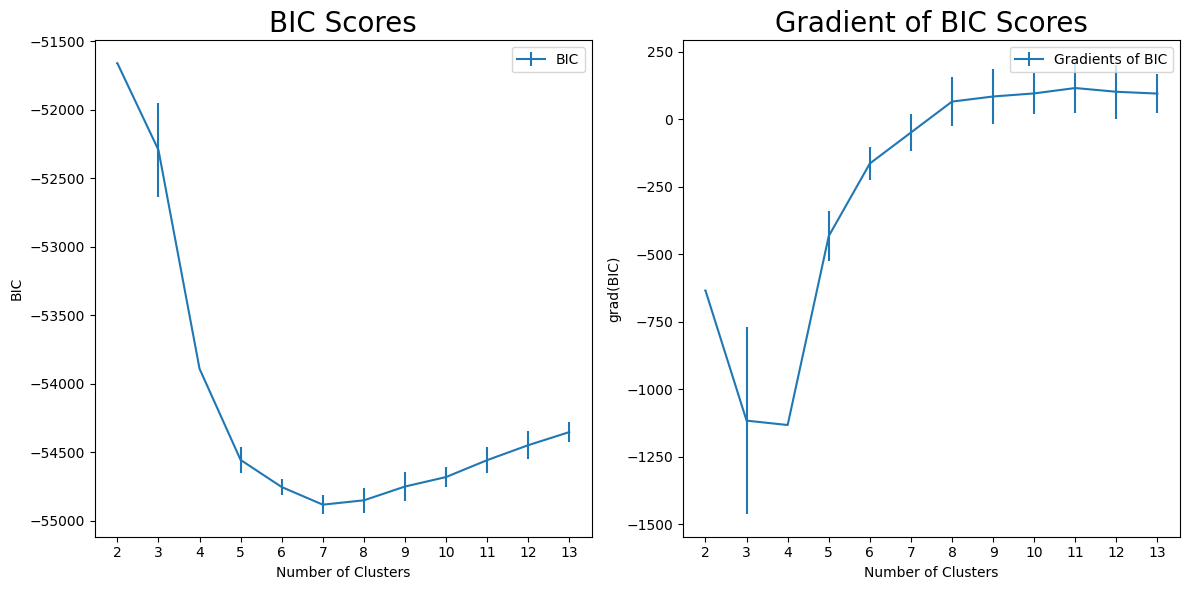


Class 1:
n_clusters: 12, bics: 12, bics_err: 12, gradients: 12


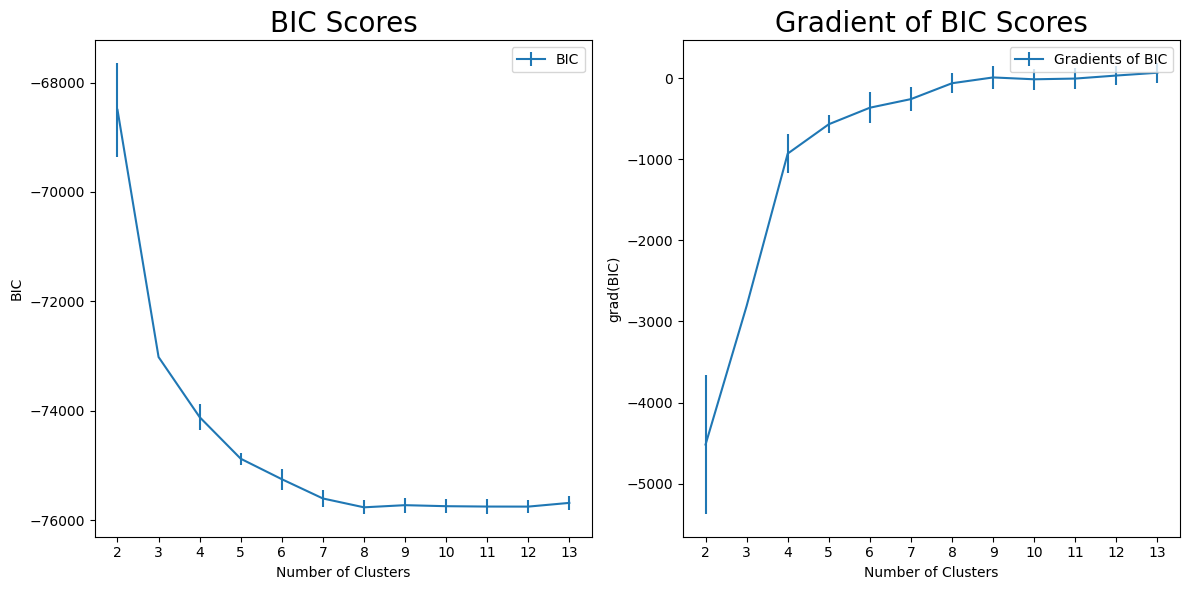

In [ ]:
# assumption 5 part 1

# define cluster range
n_clusters_range = np.arange(2, 14) # try  20

# calculate GMMs and BICs
gmms, bics, bics_err = gmms_bics(features, labels, n_clusters_range)

# plot BICs for each class
for label in bics.keys():
    print(f"\nClass {label}:")
    plot_bic_and_gradient(n_clusters_range, bics[label], bics_err[label])

We see that from the cluster size of seven for the first class and four for the second class, respectively, the gradient becomes almost constant(flatten) and the original function has a more gentle decrease, so there is no much gain in increasing the number of clusters. Therefor, with this technique, we suggest to use seven and four clusters.

In [ ]:
# assumption 5 part 2
folds = 4 # ensure that we run for 4 partitions on the data for cross-validation

# define optimal clusters based on visual observation y hand
optimal_n_clusters_dict = {
    0: 7,  # clusters for 1st class
    1: 4   # clusters for 2nd class
}

# gmms with optimal clusters
optimal_gmms_results = optimal_gmms(gmms, n_clusters_range, optimal_n_clusters_dict)

# apply the classifier using optimal gmms
accuracy = cross_validation_bayes_assumption_5(features, labels, folds, optimal_gmms_results)
print(f"\nAverage Cross-Validation Accuracy (Assumption 5): {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Likelihood (scalar): 17.303656918340966
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 18.232754483280242
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 15.161260704430129
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 17.61772599606808
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 5.833412133801419
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 17.714654054912078
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 17.472254224413486
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 18.124924057262476
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 11.316935181774145
Class 1:
Prior(scalar): 0.4296710986703989
Likelihood (scalar): 17.595896624215925
Prediction: 1
Class 0:
Prior(scalar): 0.5703289013296011
Likelihood (scalar): 18.06779808034164
Class 1:
Pri

Having calculated the accuracy of bayes/naive bayes classifiers for all assumption for the first dataset, we proceed to follow the exactly the same process for the second dataset and discuss the results at the end.

### 2.2.2. Bayes Classifiers on Red_Wine_Quality dataset.

In [ ]:
# parameters
folds = 4  # number of folds for cross-validation

assumption = 'assumption_1'  # assumption

# reminder: wine_features var contains feature matrix and wine_labels var contains target vector for dataset_2

# apply the classifier
accuracy = cross_validation_bayes(wine_features, wine_labels, folds, assumption)
print(f"Average Cross-Validation Accuracy (Assumption 1): {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Likelihood (scalar): 404.4237515099506
Posterior(scalar): 5.271349439652833
Prediction: 1

Sample: [0.31858407 0.07534247 0.42       0.06849315 0.0951586  0.11267606
 0.03886926 0.27092511 0.37007874 0.1257485  0.6       ]
Class 0:
Prior(scalar): 0.5186274509803922
Likelihood (scalar): 31.46792253464154
Posterior(scalar): 2.7923992203254264
Class 1:
Prior(scalar): 0.48137254901960785
Likelihood (scalar): 688.3710018341152
Posterior(scalar): 5.803214160960123
Prediction: 1

Sample: [0.39823009 0.12328767 0.41       0.07534247 0.09348915 0.12676056
 0.06360424 0.37885463 0.41732283 0.31137725 0.50769231]
Class 0:
Prior(scalar): 0.5186274509803922
Likelihood (scalar): 329.9467246173398
Posterior(scalar): 5.142361726454064
Class 1:
Prior(scalar): 0.48137254901960785
Likelihood (scalar): 7899.136628594015
Posterior(scalar): 8.243394966479254
Prediction: 1

Sample: [0.30973451 0.45205479 0.1        0.16438356 0.13021703 0.04225352
 0.0247349

In [ ]:
# assumption 2

assumption = 'assumption_2'  # update assumption

# apply the classifier
accuracy = cross_validation_bayes(wine_features, wine_labels, folds, assumption)
print(f"Average Cross-Validation Accuracy (Assumption 2): {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Likelihood (scalar): 105369.3492991582
Posterior(scalar): 10.834113290700731
Prediction: 1

Sample: [0.31858407 0.07534247 0.42       0.06849315 0.0951586  0.11267606
 0.03886926 0.27092511 0.37007874 0.1257485  0.6       ]
Class 0:
Prior(scalar): 0.5186274509803922
Likelihood (scalar): 98.68907163112407
Posterior(scalar): 3.93540474280025
Class 1:
Prior(scalar): 0.48137254901960785
Likelihood (scalar): 25213.73167657309
Posterior(scalar): 9.404030254407893
Prediction: 1

Sample: [0.39823009 0.12328767 0.41       0.07534247 0.09348915 0.12676056
 0.06360424 0.37885463 0.41732283 0.31137725 0.50769231]
Class 0:
Prior(scalar): 0.5186274509803922
Likelihood (scalar): 3990.4486042765425
Posterior(scalar): 7.635089461293381
Class 1:
Prior(scalar): 0.48137254901960785
Likelihood (scalar): 622876.7585137675
Posterior(scalar): 12.610990180316904
Prediction: 1

Sample: [0.30973451 0.45205479 0.1        0.16438356 0.13021703 0.04225352
 0.024734

In [ ]:
# assumption 3

assumption = 'assumption_3'  # update assumption

# apply the classifier
accuracy = cross_validation_bayes(wine_features, wine_labels, folds, assumption)
print(f"Average Cross-Validation Accuracy (Assumption 3): {accuracy:.2f}%")

Clssifier: Naive Bayes
Clssifier: Naive Bayes

Sample: [0.24778761 0.39726027 0.         0.06849315 0.10684474 0.14084507
 0.09893993 0.56754772 0.60629921 0.13772455 0.15384615]
Class 1:
Prior(scalar): 0.5617647058823529
Likelihoods(list): [2.1884335548036673, 1.3043089693771919, 0.6117341084937364, 3.83818063111176, 6.4814412305062925, 2.4710127320576856, 3.97691664127334, 1.9309929025988548, 1.4552287693165187, 3.2612506796009675, 0.7662019309354633]
Length of likelihoods(=same as features): 11
Likelihood (scalar): 8.005476765876182
Posterior(scalar): 1.503453713622017
Class 0:
Prior(scalar): 0.43823529411764706
Likelihoods(list): [2.415663834951049, 2.640366982237132, 0.9464771458339586, 3.6103476234580074, 5.18492297771331, 2.2034562332241667, 2.7834289956994565, 2.8896535717903507, 1.3951943347773725, 4.519707741690953, 2.4166995378099387]
Length of likelihoods(=same as features): 11
Likelihood (scalar): 10.326173853652183
Posterior(scalar): 1.5096825111464436
Prediction: 0

Samp

<ipython-input-12-33b886c91b3b>:71: RuntimeWarning: invalid value encountered in log
  posts[class_label] = np.log(prior) + np.log(likelihood) # take the log(posterior)=log(likelihood*prior)=log(likelihood) + log(prior)


Streaming output truncated to the last 5000 lines.
Likelihood (scalar): 11.138765223516657
Posterior(scalar): 1.7762927592288145
Prediction: 1

Sample: [0.7079646  0.18493151 0.49       0.10958904 0.11352254 0.09859155
 0.04946996 0.67033774 0.25984252 0.29341317 0.29230769]
Class 0:
Prior(scalar): 0.4696078431372549
Likelihoods(list): [0.09010207726048879, 1.8004224559719841, 0.9901502930871146, 4.732853904046449, 3.768157738284104, 1.961431749527135, 1.8015650481058527, 1.720794833119459, 1.0982800149636291, 2.1761593032144817, 2.88487514446617]
Length of likelihoods(=same as features): 11
Likelihood (scalar): 4.7883305767931486
Posterior(scalar): 0.8103245192171523
Class 1:
Prior(scalar): 0.5303921568627451
Likelihoods(list): [0.3207883228504883, 3.2846946316356336, 1.4442662881630173, 4.704976787574339, 5.862690656397022, 2.291421429164555, 3.211721542028737, 1.2926597315863837, 1.1524537028993251, 3.1006108105709007, 2.016610710443128]
Length of likelihoods(=same as features): 11


In [ ]:
# assumption 4

assumption = 'assumption_4'  # update assumption

# apply the classifier
accuracy = cross_validation_bayes(wine_features, wine_labels, folds, assumption)
print(f"Average Cross-Validation Accuracy (Assumption 4): {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Likelihood (scalar): 32.37201934687039
Prediction: 1
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 44.63759032614957
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 41.356267687619415
Prediction: 1
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 26.92451716859916
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 23.960012488105733
Prediction: 1
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 29.795275569872068
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 25.081926091870343
Prediction: 1
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 43.270920087093245
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 41.065532776560836
Prediction: 1
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 37.4571121242589
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 36.20570021549871
Prediction: 1
C


Class 0:
n_clusters: 12, bics: 12, bics_err: 12, gradients: 12


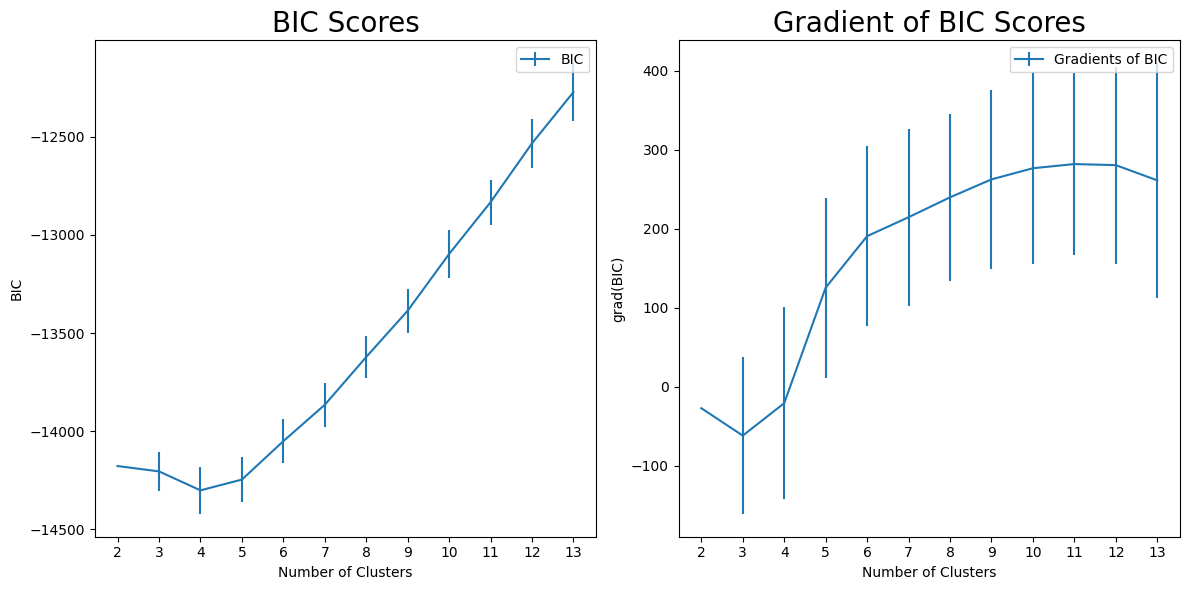


Class 1:
n_clusters: 12, bics: 12, bics_err: 12, gradients: 12


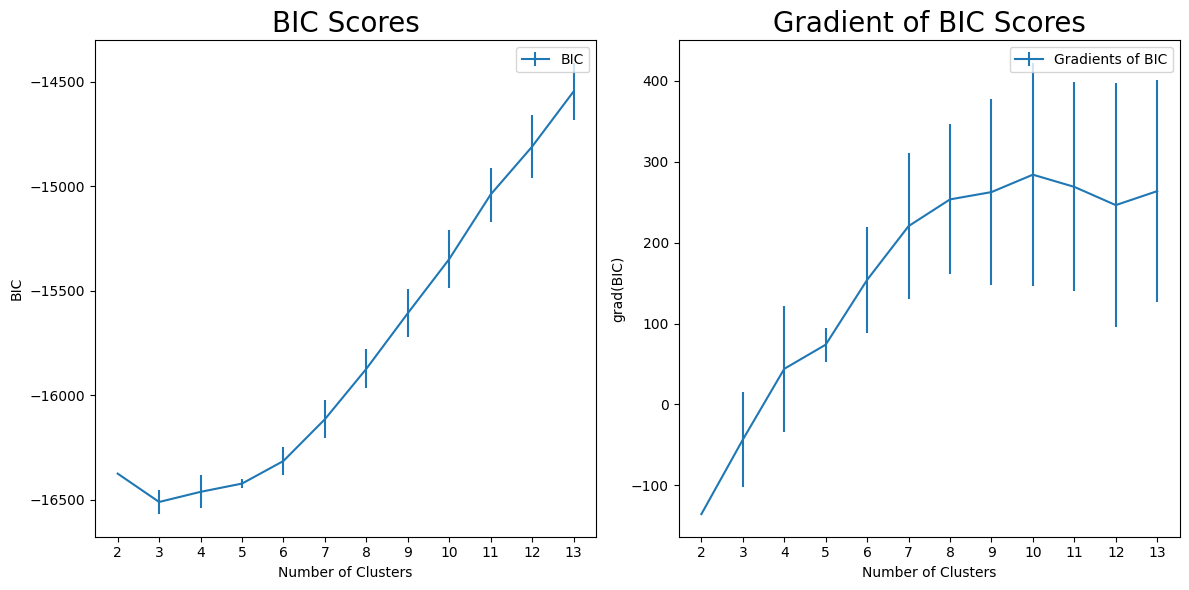

In [ ]:
# assumption 5 part 1

# define cluster range
n_clusters_range = np.arange(2, 14)

# calculate GMMs and BICs
gmms, bics, bics_err = gmms_bics(wine_features, wine_labels, n_clusters_range)

# plot BICs for each class
for label in bics.keys():
    print(f"\nClass {label}:")
    plot_bic_and_gradient(n_clusters_range, bics[label], bics_err[label])

We observe that from the cluster size of five for the first class and seven for the second class, the gradient becomes almost constant, like in the previous dataset, so there is no much gain in increasing the number of clusters. Thus, with this technique, we suggest to use five and seven clusters.

Another noticeable observation is that, in this case with a smaller dataset, there is an increase in BIC values as the number of clusters is increasing, in comparison with the previous, larger, dataset case. As provided in the equation in the beginning of the section, BIC is affected by both the likelihood term and the complexity(penalty) term. For larger datsets, the likelihood term outweights the second term, resulting a decreasing BIC line, even $klog(n)$ is very large. In smaller datasets, the opposite happens and the second term dominates, leading to an increasing BIC line. And this is how Bayesian Information Criterion represents the balance we should target to have between the model's accuracy and complexity.

In [ ]:
# assumption 5 part 2

# define optimal clusters based on visual observation y hand
wine_optimal_n_clusters_dict = {
    0: 5,  # clusters for 1st class
    1: 7   # clusters for 2nd class
}

# gmms with optimal clusters
wine_optimal_gmms_results = optimal_gmms(gmms, n_clusters_range, wine_optimal_n_clusters_dict)

# apply the classifier using optimal gmms
accuracy = cross_validation_bayes_assumption_5(wine_features, wine_labels, folds, wine_optimal_gmms_results)
print(f"\nAverage Cross-Validation Accuracy (Assumption 5): {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Prediction: 0
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 17.79452657207463
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 15.272154074695505
Prediction: 0
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 10.112710125498923
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 9.022346894644151
Prediction: 0
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 12.986609653853735
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 10.201705293514525
Prediction: 0
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 17.207393278962734
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 16.9127229789638
Prediction: 0
Class 0:
Prior(scalar): 0.4568627450980392
Likelihood (scalar): 15.192520773863935
Class 1:
Prior(scalar): 0.5431372549019607
Likelihood (scalar): 13.91867930948297
Prediction: 0
Class 0:
Prior(scalar): 0.45686274509803

## 2.3. Table Results.

The table below shows us all the accuracy results from the experiments conducted for k-NN and bayes classifier of all the assumptions for the two datasets. Dataset $1$ is the given Rice_Cammeo_Osmancik with $3810$ samples(big) along with a $7$ dimensional feature space and the dataset $2$ is the winequality-red with $1359$ samples(small) with $11$ feature-columns.

| Model         | Dataset 1 (big) | Dataset 2 (small) |
|---------------|-----------|-----------|
| k-NN (k=9)      | 92.96%       | 73.01%       |
| k-NN (k=31)      | 92.70%       | 73.38%       |
| k-NN (k=51)      | 92.78%       | 73.01%       |
| k-NN (k=401)      | 92.28%       | 71.31%       |
| Bayes (assumption 1)      | 88.71%       | 71.17%       |
| Bayes (assumption 2)      | 90.99%       | 71.31%       |
| Naive Bayes (assumption 3)      | 40.44%       | 58.85%       |
| Naive Bayes (assumption 4)      | 75.11%       | 57.23%       |
| Bayes (assumption 5)      | 91.52%       | 82.08%       |


Discuss the results.

Let's start comparing all bayes classification results for all assumptions. In both cases of datasets, the model's descsending order regarding accuracy is the same. Gaussian mixtures models with EM and BIC give us the highest accuracies(assumption 5). It seems that a linear combination of gaussians can capture complex data distributions(not only gaussian distributions!) and return us very accurate predictions. We get second highest accuracies by calculating likelihood of gaussian pdfs assuming non-diagonal covariance matrices. Non-diagonal matrices(assumption 2) allow the model to capture correlations between features, making it more flexible and finally better than those models with zero-diagonal matrices, in which we don't have any information about feataure correlation(assumption 1). However, the case of bayes classifier with zero-diagonal covariance matrix gives better results than naive bayes cases. Naive bayes with statistically full independence between feature vectors, something rare in real-world, gives us really low accuracies. The independence assumption leads to oversimplified seperating lines(decision boundaries), making the model unable to capture significant feature dependencies. But, what is interesting here, is that basic Naive bayes classifier(assumption 3) is performing better than Naive bayes with Parzen windows kernels(assumption 4) when we have a small dataset. And here it comes the sensitivity of Parzen windows non-parametric method to the size of the dataset(and to the length of the bin/kernel). For larger datasets, calculating likelihoods with parzen window kernels can give us very descent results, while for smaller datasets the model is getting improper with very bad performance(maybe worse than basic Naive bayes). Overall, we get higher accuracies for the big dataset in comparison with the small one, obviously, and this is because of the size of samples of the dataset.

Let's compare now the results of version of bayes classifiers with k-NN. We should not forget that k-NN is free of assumptions and benefits from the dataset as it is, while in contrast, in Bayes versions, we take into account some assumptions/limitations on data samples. As we see, for the big dataset,  k-NN is almost the same(slightly better) with the best version of bayes classifier with gaussians mixture, while for the smaller dataset, the opposite happens with higher gap between their accuracies. Regarding k-NN vs. Naive Bayes classifiers, k-NN captures feature dependencies as it uses distances in the feature space, while Naive Bayes classifiers are limited to feature independencies, so, k-NN will perform better than all Naive Bayes classifiers versions.

One general observation is that, almost always and in all cases, there will be always a trade-off between model's complexity and generalization as well as any assumptions about the data.

To sum up, as we increase the $N$, $k$-NN reaches best Bayes versions, beacause it effectively captures all local dependencies without relying on any assumption on data distributions. On the small dataset, k-NN cannot take good decisions and Bayes versions perform better as their assumptions lead to more effective generalization, despite the limited data.

Additional Notes:

For the implementation of question five in Problem 2, we use the scikit library for the calculation of pdfs with gaussian mixtures as well as BIC calculations(with exactly the same code as in the provided source). It might be an update of this notebook with a custom gaussian mixture class and a BIC calculataion function later in time.